# Dissertation Project

Student Name: Priyal Agarwal

Student ID: 21132259

## Importing Libraries and Modules

In [31]:
# Importing basic python Libraries 

import numpy as np
import pandas as pd
import re 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [32]:
# Importing Libraries for web scraping

import requests
from bs4 import BeautifulSoup

In [ ]:
# Importing NLTK packages and modules

import nltk
nltk.download('popular')
from nltk.corpus import stopwords, words
from string import punctuation
import string 
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

In [ ]:
# Making some backend fixes to properly install and load the 'pyenchant/enchant' library

!apt update
!apt install enchant --fix-missing
!apt install -qq enchant
!pip install pyenchant 

In [35]:
# importing the enchant library

import enchant
d = enchant.Dict("en_GB")

# adding the most important medical term (for this project) in the dictionary because it does not exist
d.add('colorectal')

## Loading Initial Dataset

Dataset with links of webpages.

In [38]:
df = pd.read_csv('/content/InitialDataset.csv', header=0)
df.head(10)

,Title,Link
0,Colon cancer - Symptoms and causes - Mayo Clinic,https://www.bing.com/ck/a?!&&p=d95f1707b5878ca...
1,"Colon Cancer: Symptoms, Stages, Outlook, and More",https://www.bing.com/ck/a?!&&p=562e3c38f7996e1...
2,Signs and Symptoms of Colon Cancer,https://www.bing.com/ck/a?!&&p=a339ef2f3b3886b...
3,Bowel (colorectal) cancer | Irish Cancer Society,https://www.bing.com/ck/a?!&&p=4b8f3e854b0f269...
4,Colon cancer - Macmillan Cancer Support,https://www.bing.com/ck/a?!&&p=853cad51b70e95b...
5,"Colon Cancer Symptoms, Survival Rate, Treatmen...",https://www.bing.com/ck/a?!&&p=ea123706634c2f9...
6,Colon Cancer: 8 Early Warning Signs and 4 Stages,https://www.bing.com/ck/a?!&&p=f95e5a0ef67923f...
7,Colorectal cancer - Wikipedia,https://www.bing.com/ck/a?!&&p=1867286e414e465...
8,Bowel cancer - NHS,https://www.bing.com/ck/a?!&&p=86d2a83624a110e...
9,"Colon Cancer Symptoms, Survival Rate, Treatmen...",https://www.bing.com/ck/a?!&&p=f0cebf21acf47dd...


## Creating Final Dataset

Going through all the steps of processing to create the final Dataset.

#### Step 1:

In [39]:
# Step 1: Generating the csv with actual links of the webpages

links = []
for l in df['Link']:
    i = 0
    url = l
    try:
        page = requests.get(url)        #to extract page from website
        html_code = page.content        #to extract html code from page
        # print(type(html_code))
    except Exception as e:
        print("This is Error",e)

    try:
        soup = BeautifulSoup(html_code, 'html.parser')  #Parse html code
        texts = soup.findAll(text=True)                 #find all text
        text_from_html = ' '.join(texts)                #join all text
    except Exception as e:
        print(e)

    lst = text_from_html.split('\n')          # obtaining a google redirect document that contains the actual link to the webpage

    for i in range(len(lst)):
        lst[i] = lst[i].strip()

    lst = list(filter(None, lst))

    links.append(lst[28].split('\"')[1])      # storing the actual link from the 29th line of the redirect document

df['Link'] = links                            # replacing the bing.com links in the initial datafram with the actual links
df.head()

,Title,Link
0,Colon cancer - Symptoms and causes - Mayo Clinic,https://www.mayoclinic.org/diseases-conditions...
1,"Colon Cancer: Symptoms, Stages, Outlook, and More",https://www.healthline.com/health/colon-cancer
2,Signs and Symptoms of Colon Cancer,https://www.cancer.org/latest-news/signs-and-s...
3,Bowel (colorectal) cancer | Irish Cancer Society,https://www.cancer.ie/cancer-information-and-s...
4,Colon cancer - Macmillan Cancer Support,https://www.macmillan.org.uk/cancer-informatio...


#### Step 2:

In [40]:
# Step 2: Scraping webpage data using the actual links

txt = []

for l in df['Link']:
    url = l
    try:
        page = requests.get(url)        #to extract page from website
        html_code = page.content        #to extract html code from page
    except Exception as e:
        print("Error in retrieving webpage:",e)

    try:
        soup = BeautifulSoup(html_code, 'html.parser')  #Parse html code
        texts = soup.findAll(text=True)                 #find all text
        text_from_html = ' '.join(texts)                   #join all text
    except Exception as e:
        print(e)

    txt.append(" ".join(text_from_html.split()))

df['data'] = txt
df.head()

,Title,Link,data
0,Colon cancer - Symptoms and causes - Mayo Clinic,https://www.mayoclinic.org/diseases-conditions...,html googleoff: all Colon cancer - Symptoms an...
1,"Colon Cancer: Symptoms, Stages, Outlook, and More",https://www.healthline.com/health/colon-cancer,"html Colon Cancer: Symptoms, Stages, Outlook, ..."
2,Signs and Symptoms of Colon Cancer,https://www.cancer.org/latest-news/signs-and-s...,html Signs and Symptoms of Colon Cancer window...
3,Bowel (colorectal) cancer | Irish Cancer Society,https://www.cancer.ie/cancer-information-and-s...,html form.antibot * :not(.antibot-message) { d...
4,Colon cancer - Macmillan Cancer Support,https://www.macmillan.org.uk/cancer-informatio...,"html [if lt IE 7]> <html class=""no-js lt-ie9 l..."


In [ ]:
# Saving the intermediate dataset in order to not revisiting the website on every execution and avoid getting blocked by the websites as an DDOS attacker.

csv_data = df.to_csv('WebData.csv')
from google.colab import files
files.download('WebData.csv') 

#### Step 3:

Processisng the webpage data

In [41]:
# Creating a set of stop strings. These include stop words of the English language, punctuations, and some unimportant words.

punc = set(punctuation)
stw = set(stopwords.words("english"))

stop = stw.union(punc)

stop.update(['exit', 'fonts', 'header', 'comments', 'hide',
             'author', 'format', 'site', 'var', 'id', 
             'error', 'document', 'window', 'org', 'com',
             'cache', 'server', 'script', 'search', 'version',
             'request', 'data', 'page', 'function', 'body' ])

In [42]:
# Creating a function to filter out further unimportant elements from the webpage data

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;.]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
REMOVE_NUM = re.compile('[\d+]')

def cleaning(text):
    # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 

    # Remove numbers
    text = REMOVE_NUM.sub('', text)

    #  delete symbols which are in BAD_SYMBOLS_RE from text
    text = BAD_SYMBOLS_RE.sub('', text) 

    # delete stopwords from text
    text = ' '.join(word for word in text.split() if word not in stop)

    return text

In [43]:
# Defining a function to generate the POS tags of words

def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [44]:
# Defining the Lemmatizer instance

lem=WordNetLemmatizer()

In [45]:
# Putting all the functions together and preprocessing the webpage data so as to generate Bag Of Words for each document.

corpus = []
bow_main = []
for data in df['data']:
    data = cleaning(data.lower())
    words = set(word_tokenize(data))
    bow = []
    for w,t in pos_tag(words):
        if len(w)>2 and w not in stop:
            if w in corpus:
                bow.append(w)
                continue
            
            word_id = w
            if d.check(word_id):
                corpus.append(word_id)
                bow.append(word_id)
                continue

            word_id = lem.lemmatize(w,get_simple_pos(t))
            if word_id in corpus:
                bow.append(word_id)
                continue
            if d.check(word_id):
                corpus.append(word_id)
                bow.append(word_id)

    bow_main.append(' '.join(bow))

df['BOW'] = bow_main
df.head()

,Title,Link,data,BOW
0,Colon cancer - Symptoms and causes - Mayo Clinic,https://www.mayoclinic.org/diseases-conditions...,html googleoff: all Colon cancer - Symptoms an...,heavy develop one getting analysis endorse tra...
1,"Colon Cancer: Symptoms, Stages, Outlook, and More",https://www.healthline.com/health/colon-cancer,"html Colon Cancer: Symptoms, Stages, Outlook, ...",heavy develop source kill one honest written m...
2,Signs and Symptoms of Colon Cancer,https://www.cancer.org/latest-news/signs-and-s...,html Signs and Symptoms of Colon Cancer window...,precancerous source calculator equity back one...
3,Bowel (colorectal) cancer | Irish Cancer Society,https://www.cancer.ie/cancer-information-and-s...,html form.antibot * :not(.antibot-message) { d...,adolescents researchers stomach back absorbed ...
4,Colon cancer - Macmillan Cancer Support,https://www.macmillan.org.uk/cancer-informatio...,"html [if lt IE 7]> <html class=""no-js lt-ie9 l...",documentation rid success trustworthy tailored...


In [ ]:
# Saving and downloading the finally generated dataframe as the Final Dataset, in CSV format

csv_data = df.to_csv('FinalCSV.csv')
from google.colab import files
files.download('FinalCSV.csv')

## Clustering

In [47]:
# Loading the dataset.

df = pd.read_csv("/content/FinalCSV.csv")
df = df.drop('Unnamed: 0', axis=1)
df.head()

,Title,Link,data,BOW
0,Colon cancer - Symptoms and causes - Mayo Clinic,https://www.mayoclinic.org/diseases-conditions...,html googleoff: all Colon cancer - Symptoms an...,proceedings reserved reducing likely known dev...
1,"Colon Cancer: Symptoms, Stages, Outlook, and More",https://www.healthline.com/health/colon-cancer,"html Colon Cancer: Symptoms, Stages, Outlook, ...",depressed kits shares reserved reducing likely...
2,Signs and Symptoms of Colon Cancer,https://www.cancer.org/latest-news/signs-and-s...,html Signs and Symptoms of Colon Cancer window...,consent intended doctor reserved many diagnose...
3,Bowel (colorectal) cancer | Irish Cancer Society,https://www.cancer.ie/cancer-information-and-s...,html form.antibot * :not(.antibot-message) { d...,chemo reserved stats rectum liver made known b...
4,Colon cancer - Macmillan Cancer Support,https://www.macmillan.org.uk/cancer-informatio...,"html [if lt IE 7]> <html class=""no-js lt-ie9 l...",timing floor void patch preview manager chat f...


In [48]:
# Dropping the rows with NAN values

df = df.dropna()
len(df)

362

In [49]:
# Counting the number of news article webpages in the dataset

count = 0
print("Output:\n")
for title in df['Title']:
    if 'news' in title.lower():
        count+=1
        print(title)

print("\nThe count of News Webpages in the dataset is:", count)

Output:

Colorectal Cancer Pathogenesis - Medical News
Carbs and gut microbes fuel colon cancer | Science News
Colorectal Cancer Pathogenesis - Medical News
Carbs and gut microbes fuel colon cancer | Science News
Colon cancer - News and Latest Updates - Medical Xpress
Colon cancer - News and Latest Updates - Medical Xpress
10 myths about colon cancer - CBS News
Colorectal Cancer Diagnosis - Medical News

The count of News Webpages in the dataset is: 8


#### Vectorizing the textual data

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(sublinear_tf= True,
                             min_df=5, 
                             norm='l2',
                             ngram_range=(1, 3),
                             stop_words='english')

X_train_vc = vectorizer.fit_transform(df['BOW'])  # Vectorizing the bag of words

pd.DataFrame(X_train_vc.toarray(), columns=vectorizer.get_feature_names()).head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abbr,abbreviations,abdomen,abdomen procedures,abdomen procedures society,abdomen society,abdomen usually,abdominal,abdominal grown,abdominal initial,...,youngest,youth,youth menu,youth menu callback,yrs,zero,zip,zone,zone chances,zoom
0,0.000000,0.0,0.021579,0.032648,0.0,0.000000,0.0,0.018923,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.022901,0.0,0.016400,0.000000,0.0,0.025846,0.0,0.014381,0.028616,0.0,...,0.0,0.024501,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.000000,0.0,0.026826,0.000000,0.0,0.000000,0.0,0.023523,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.030753,0.0,0.0


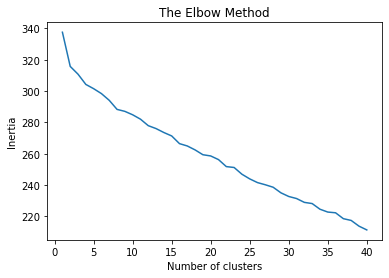

In [51]:
# Elbow Method to find the optimal number of clusters in the data.

k_clusters = 40    # The number of clusters can be modified here

score = []
for i in range(1,k_clusters + 1):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=5,random_state=0)
    kmeans.fit(X_train_vc)
    score.append(kmeans.inertia_)
plt.plot(range(1,k_clusters + 1 ),score)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.savefig('elbow40.png')      # Saving the resultant graph
plt.show()

In [52]:
# Trying to obtain two clusters from the data.

k_clusters = 2

model = KMeans(n_clusters=k_clusters, init='k-means++', n_init=10, max_iter=600, tol=0.000001, random_state=0)
model.fit(X_train_vc)           # fitting the obtained vectors on the instance of K-means

KMeans(max_iter=600, n_clusters=2, random_state=0, tol=1e-06)

In [53]:
# predicting the clusters of the data points
clusters = model.predict(X_train_vc)

In [54]:
# appending the assigned clusters in the dataframe 

df["Cluster"] = clusters
df.head()

,Title,Link,data,BOW,Cluster
0,Colon cancer - Symptoms and causes - Mayo Clinic,https://www.mayoclinic.org/diseases-conditions...,html googleoff: all Colon cancer - Symptoms an...,proceedings reserved reducing likely known dev...,0
1,"Colon Cancer: Symptoms, Stages, Outlook, and More",https://www.healthline.com/health/colon-cancer,"html Colon Cancer: Symptoms, Stages, Outlook, ...",depressed kits shares reserved reducing likely...,0
2,Signs and Symptoms of Colon Cancer,https://www.cancer.org/latest-news/signs-and-s...,html Signs and Symptoms of Colon Cancer window...,consent intended doctor reserved many diagnose...,0
3,Bowel (colorectal) cancer | Irish Cancer Society,https://www.cancer.ie/cancer-information-and-s...,html form.antibot * :not(.antibot-message) { d...,chemo reserved stats rectum liver made known b...,0
4,Colon cancer - Macmillan Cancer Support,https://www.macmillan.org.uk/cancer-informatio...,"html [if lt IE 7]> <html class=""no-js lt-ie9 l...",timing floor void patch preview manager chat f...,0


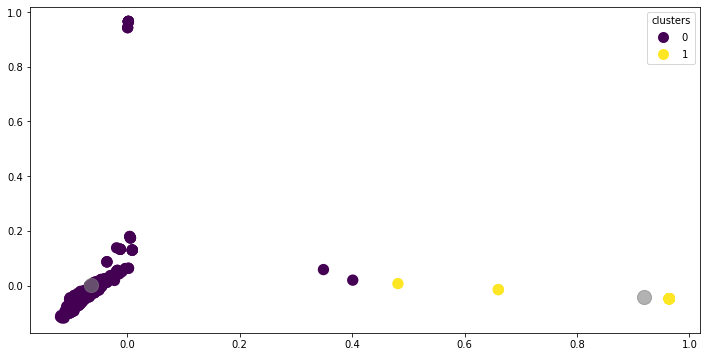

In [55]:
# Plotting the clusters 

# using PCA to obtain two features against which the clusters can be plotted
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(X_train_vc.toarray())
kmeans = KMeans(n_clusters=k_clusters, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

fig, ax = plt.subplots(figsize=(12, 6))

sc = ax.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=40, cmap='viridis', linewidths=5)
ax.legend(*sc.legend_elements(), title='clusters')

centers = fitted.cluster_centers_

sc2 = ax.scatter(centers[:, 0], centers[:, 1],c='grey', s=200, alpha=0.6);

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


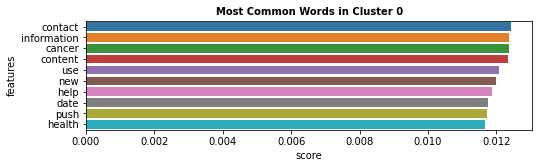

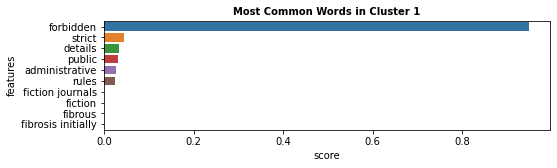

In [56]:
# defining functions to get the top common words of a cluster

# Function to get top common words of a cluster
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs


# function to graphically display top common words of a cluster
def plotWords(dfs, n_feats):
    for i in range(0, len(dfs)):
        plt.figure(figsize=(8, 2))
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])


dfs = get_top_features_cluster(X_train_vc.toarray(), prediction, 10)   # function call to get 10 most common words of each cluster
plotWords(dfs, 13)         # function call to display 10 most common words of each cluster